<a href="https://colab.research.google.com/github/anastasiarenata1/deeplearning/blob/main/LNN_with_Numpy_and_Softmax_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 4 - Regression

Classification data from 2011 Million Song Challenge dataset to predict music year

* Explore three shallow (linear) neural network models with different activation functions for this task.
* Evaluate the model by rounding the output of your linear neural network and compute the mean squared error


###1. Load and explore the data

In [120]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
!unzip YearPredictionMSD.txt.zip

--2023-03-03 05:31:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘YearPredictionMSD.txt.zip’

YearPredictionMSD.t 100%[===================>] 201.24M  18.1MB/s    in 12s     

2023-03-03 05:31:28 (16.4 MB/s) - ‘YearPredictionMSD.txt.zip’ saved [211011981/211011981]

Archive:  YearPredictionMSD.txt.zip
  inflating: YearPredictionMSD.txt   


In [119]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [121]:
colnames = ['target'] + ['timbre_avg_' + str(i) for i in range(1, 13)] + ['timbre_covar_' + str(i) for i in range(1, 79)]
df = pd.read_csv('YearPredictionMSD.txt', header=None, names=colnames)
df.head(5)

,target,timbre_avg_1,timbre_avg_2,timbre_avg_3,timbre_avg_4,timbre_avg_5,timbre_avg_6,timbre_avg_7,timbre_avg_8,timbre_avg_9,...,timbre_covar_69,timbre_covar_70,timbre_covar_71,timbre_covar_72,timbre_covar_73,timbre_covar_74,timbre_covar_75,timbre_covar_76,timbre_covar_77,timbre_covar_78
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Write a function to load the dataset, e.g.,
`trainYears, trainFeat, testYears, testFeat = loadMusicData(fname, addBias)`

In [122]:
def loadMusicData(data, addBias=True):
  train_df = data[:463714]
  test_df = data[463714:]
  train_y = train_df['target'].values
  train_x = train_df.iloc[:,1:].values
  test_y = test_df['target'].values
  test_x = test_df.iloc[:,1:].values
  if addBias:
    train_x = np.hstack((train_x, np.ones((train_x.shape[0],1))))
    test_x = np.hstack((test_x, np.ones((test_x.shape[0],1))))
  return train_y, train_x, test_y, test_x

Write a function `mse = musicMSE(pred, gt)` where the inputs are the predicted year and the “ground truth” year from the dataset. The function computes the mean squared error(MSE) by rounding pred before computing the MSE.

In [5]:
from sklearn.metrics import mean_squared_error
def musicMSE(pred, gt):
  pred = np.round(pred)
  mse= mean_squared_error(pred, gt)
  return mse

Load the dataset and discuss its properties. 
1. What is the range of the variables? From 90 attributes, range of variables for timbre average is tighter than range of variables for timbre covariance. However, within each category itself, some attributes have wider range compared to others, in which we don't have further documentation to explain this event.
2. How might you normalize them? Normalization can help to ensure that each variables contribute equally to the model. Since range of variables varies significantly accross 90 attributes, I will normalize the data using standardization technique (0 mean and unit std deviation for each attribute) where we can help to preserve importance of variables.
3. What years are represented in the dataset? The dataset covers song released from 1922 to 2011 (90 years) with most common year of 2007.
4. What will the test mean squared error (MSE) be if your classifier always outputs the most common year in the dataset? 190.08

In [6]:
# Range of variables
var_ranges = np.ptp(df.iloc[:, 1:].values, axis=0)
for i, var_range in enumerate(var_ranges):
    print("Variable {}: range = {:.0f}".format(i+1, var_range))

Variable 1: range = 60
Variable 2: range = 721
Variable 3: range = 624
Variable 4: range = 490
Variable 5: range = 444
Variable 6: range = 248
Variable 7: range = 361
Variable 8: range = 199
Variable 9: range = 273
Variable 10: range = 102
Variable 11: range = 158
Variable 12: range = 182
Variable 13: range = 550
Variable 14: range = 65727
Variable 15: range = 36796
Variable 16: range = 31832
Variable 17: range = 19854
Variable 18: range = 16826
Variable 19: range = 11882
Variable 20: range = 9564
Variable 21: range = 9610
Variable 22: range = 3707
Variable 23: range = 6731
Variable 24: range = 9808
Variable 25: range = 4871
Variable 26: range = 37870
Variable 27: range = 26522
Variable 28: range = 7735
Variable 29: range = 6635
Variable 30: range = 6669
Variable 31: range = 6153
Variable 32: range = 3471
Variable 33: range = 4567
Variable 34: range = 3921
Variable 35: range = 2803
Variable 36: range = 4208
Variable 37: range = 22597
Variable 38: range = 18155
Variable 39: range = 1586

In [123]:
#Normalize data using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def loadMusicData2(data, addBias=True):
  train_df = data[:463714]
  test_df = data[463714:]
  train_y = train_df['target'].values
  train_x = train_df.iloc[:,1:].values
  test_y = test_df['target'].values
  test_x = test_df.iloc[:,1:].values
  train_x= scaler.fit_transform(train_x)
  test_x= scaler.fit_transform(test_x)

  if addBias:
    train_x = np.hstack((train_x, np.ones((train_x.shape[0],1))))
    test_x = np.hstack((test_x, np.ones((test_x.shape[0],1))))
  

  return train_y, train_x, test_y, test_x

In [8]:
#Years represented
print('Min years presented: ', np.min(df['target']))
print('Max years presented: ', np.max(df['target']))
print('Median years presented: ', np.median(df['target']))

from statistics import mode
print('Most common year:', mode(df['target']))

Min years presented:  1922
Max years presented:  2011
Median years presented:  2002.0
Most common year: 2007


In [124]:
train_y, train_x, test_y, test_x = loadMusicData2(df, addBias=True)

In [10]:
#test MSE
musicMSE(torch.full((test_y.shape[0],), 2007), test_y)

190.08239236117836

##2. Classification
This problem could have been posed as a classification problem by treating each year as a category. What would be the problems with this approach? Support your argument by analyzing a bar chart with the year as the x-axis and the number of examples for that year as the y-axis.

As we can see from the chart, the distribution of train dataset is skewed to the left where majority of the data coming from the later years. If we treat this problem as a classification problem, the model will be biased and will be more likely to predict later years. Furthermore, classification means that the predicted data will be categorical values instead of continuous which can result in loss of information as repercussion. 

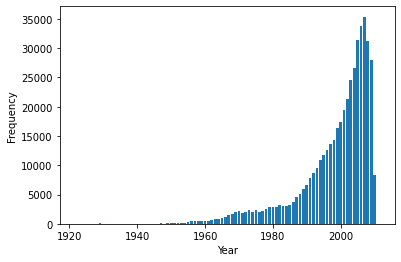

In [11]:
#plot year frequency from train dataset
import matplotlib.pyplot as plt
train_df = df[:463714]
year_counts = train_df.iloc[:, 0].value_counts()
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

##3. Ridge regression

* Implement stochastic gradient descent with mini-batches to minimize the loss and evaluate the train and test MSE.
* Tune the learning rate and weight decay factor. 
* Show the train and test loss as a function of epochs, where the number of epochs should be chosen to ensure the train loss is minimized.

In [131]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, batch_size=32, num_epochs=100, learning_rate=0.01, weight_decay_factor=0, loss_type='L2', weight_decay_form='none', momentum=False, momentum_factor=0.9):
    num_features = X_train.shape[1]
    num_batches = int(np.ceil(len(X_train) / batch_size))
    weight = np.random.normal(size=num_features)
    m = np.zeros_like(weight)
    train_losses = []
    test_losses = []

    def forward(X, w):
        return np.dot(X, w)

    def backward(X, error):
        return np.dot(X.T, error)

    def compute_gradient(X, y, y_pred, loss_type, w):
      error = None
      if loss_type == "L2":
          error = 2*(y_pred - y)
      elif loss_type == "count":
          error = np.round(y_pred) - np.round(y)
      elif loss_type == "cross-entropy":
          error = y_pred - y
      elif loss_type == 'L1':
          error = np.sign(y_pred - y)
      gradient = backward(X, error)
      if weight_decay_form == 'L2':
          gradient += weight_decay_factor * w
      elif weight_decay_form == 'L1':
          gradient += weight_decay_factor * np.sign(w)
      return gradient, error

    def compute_loss(y, y_pred, loss_type):
        if loss_type == "L2":
            return np.mean(np.square(y - y_pred))
        elif loss_type == "count":
            return np.mean(np.abs(np.round(y) - np.round(y_pred)))
        elif loss_type == "cross-entropy":
            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # clip predictions
            return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        elif loss_type == 'L1':
            return np.mean(np.abs(y - y_pred))

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(len(X_train))
        X_train = X_train[perm]
        y_train = y_train[perm]

        # Mini-batch gradient descent
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            y_pred = forward(X_batch, weight)
            gradient, error = compute_gradient(X_batch, y_batch, y_pred, loss_type, weight)

            if momentum:
              m = momentum_factor * m + (1 - momentum_factor) * gradient
              weight -= learning_rate * m
            else:
                weight -= learning_rate * gradient.reshape(weight.shape)

        # Compute train and test losses
        y_train_pred = forward(X_train, weight)
        train_loss = compute_loss(y_train, y_train_pred, loss_type)
        train_losses.append(train_loss)

        y_test_pred = forward(X_test, weight)
        test_loss = compute_loss(y_test, y_test_pred, loss_type)
        test_losses.append(test_loss)

        # print("Epoch:", epoch+1, "/100, Train loss:", train_loss, "Test loss:", test_loss)

    return weight, train_losses, test_losses


Hyperparameter tuning
* Learning rate= 0.0001
* Weight decay factor= 0.000001
* Batch size=16
* Number epochs=100
* Loss type= L2
* Weight decay form= None
* No momentum



In [13]:
w_ridge, train_loss_ridge, test_loss_ridge = mini_batch_gradient_descent(train_x, train_y, test_x, test_y, batch_size=16, num_epochs=100, learning_rate=0.000001, weight_decay_factor=0.000001, loss_type='L2', weight_decay_form=None, momentum=False, momentum_factor=None)

Epoch: 1 /100, Train loss: 625430.8533090975 Test loss: 625604.9557591722
Epoch: 2 /100, Train loss: 97931.34929725972 Test loss: 98000.50914077212
Epoch: 3 /100, Train loss: 15403.513533251424 Test loss: 15430.959171444607
Epoch: 4 /100, Train loss: 2488.9968400023317 Test loss: 2499.4241394992537
Epoch: 5 /100, Train loss: 467.8459655434799 Test loss: 471.62931146917646
Epoch: 6 /100, Train loss: 151.11942993861166 Test loss: 152.29260171769147
Epoch: 7 /100, Train loss: 101.25729928526852 Test loss: 101.37616943145912
Epoch: 8 /100, Train loss: 93.26023796641485 Test loss: 92.91398223271224
Epoch: 9 /100, Train loss: 91.87849062214063 Test loss: 91.35913995674811
Epoch: 10 /100, Train loss: 91.5740231539344 Test loss: 90.97125651696442
Epoch: 11 /100, Train loss: 91.47022185695901 Test loss: 90.79156008078887
Epoch: 12 /100, Train loss: 91.41522407752872 Test loss: 90.6906012864887
Epoch: 13 /100, Train loss: 91.37009656429386 Test loss: 90.68659816498291
Epoch: 14 /100, Train loss:

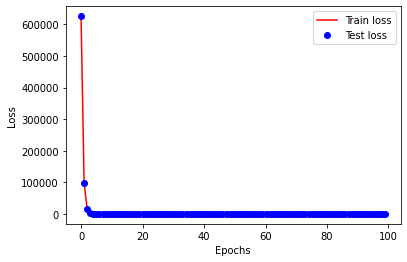

In [14]:
num_epochs=100
plt.plot(range(num_epochs), train_loss_ridge,'r', label="Train loss")
plt.plot(range(num_epochs), test_loss_ridge, 'bo',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Pseudoinverse

In [15]:
def compute_loss(X, y, weight, loss_type):
    if loss_type == 'L2':
        loss = np.mean((np.dot(X, weight) - y) ** 2)
    elif loss_type == 'count':
        loss = np.mean(np.abs(np.dot(X, weight) - y))
    elif loss_type == 'cross-entropy':
        exp_term = np.exp(np.dot(X, weight))
        loss = np.mean(np.log(1 + exp_term) - y * np.dot(X, weight))
    return loss

def pseudoinverse(train_x, train_y, test_x, test_y, alpha=0, loss_type='L2'):
    pseudoinv= np.dot(np.linalg.inv(train_x.T.dot(train_x) + alpha*np.eye(train_x.shape[1])), train_x.T)
    weight= np.dot(pseudoinv, train_y)
    train_y_predict= np.dot(train_x, weight)
    test_y_predict= np.dot(test_x, weight)

    train_loss= compute_loss(train_x, train_y, weight, loss_type=loss_type)
    test_loss= compute_loss(test_x, test_y,weight, loss_type=loss_type)
  
    print(f'Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')
    
    return weight, train_loss, test_loss

In [16]:
weight_inverse, train_loss_inverse, test_loss_inverse = pseudoinverse(train_x, train_y, test_x, test_y, alpha=0, loss_type='L2')

Train loss: 91.2564, Test loss: 90.4911


##4. Implement L1 weight decay

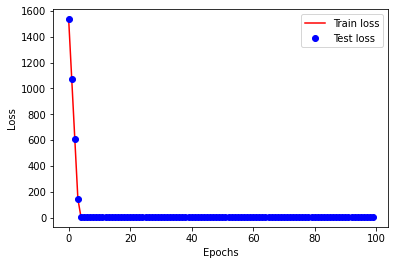

In [132]:
w_lasso, train_loss_lasso, test_loss_lasso = mini_batch_gradient_descent(train_x, train_y, test_x, test_y, batch_size=32, num_epochs=100, learning_rate=0.001, weight_decay_factor=0.01, loss_type='L1', weight_decay_form='L1', momentum=False, momentum_factor=None)
num_epochs=100
plt.plot(range(num_epochs), train_loss_lasso,'r', label="Train loss")
plt.plot(range(num_epochs), test_loss_lasso, 'bo',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
w_count, train_loss_count, test_loss_count = mini_batch_gradient_descent(train_x, train_y, test_x, test_y, batch_size=32, num_epochs=100, learning_rate=0.001, weight_decay_factor=0.01, loss_type='count', weight_decay_form='L1', momentum=False, momentum_factor=None)
num_epochs=100
plt.plot(range(num_epochs), train_loss_count,'r', label="Train loss")
plt.plot(range(num_epochs), test_loss_count, 'bo',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##5. Count Regression
\begin{align*}
y_{pred} &= e^{w^T X}\\
L(y, y_{pred}) &= e^{-y_{pred}} y_{pred}^y / y!\\
&= -\sum_{i=1}^{n}(y_i log(y_{pred,i}) - y_{pred,i})\\
\end{align*}

In [127]:
def count_regression(X_train, y_train, X_test, y_test, batch_size=16, num_epochs=100, learning_rate=0.01, weight_decay_factor=0, loss_type='count', weight_decay_form='none', momentum=False, momentum_factor=0.9):
    num_features = X_train.shape[1]
    num_batches = int(np.ceil(len(X_train) / batch_size))
    weight = np.random.normal(size=num_features)
    m = 0
    train_losses = []
    test_losses = []

    def forward(X, w):
      # Clip X * w to avoid overflow in the exponential function
      Xw = np.clip(np.dot(X, w), -1000, 500)
      # Apply the exponential function and replace any resulting inf or nan values
      y_pred = np.where(np.isinf(np.exp(Xw)), 1e10, np.exp(np.clip(Xw, -500, 500)))
      return y_pred

    def backward(X, error):
        return np.dot(X.T, error)

    def compute_gradient(X, y, y_pred, loss_type, w):
      error = None
      if loss_type == "L2":
          error = 2*(y_pred - y)
      elif loss_type == "count":
          # Clip y_pred to avoid overflow
          y_pred_clipped = np.clip(y_pred, -100, None)
          error = np.exp(-y_pred_clipped) * (y_pred - y)
      elif loss_type == "cross-entropy":
          error = y_pred - y

      gradient = backward(X, error)
      if weight_decay_form == 'L2':
          gradient += weight_decay_factor * w
      elif weight_decay_form == 'L1':
          gradient += weight_decay_factor * np.sign(w)

      return gradient, error


    def compute_loss(y, y_pred, loss_type):
      if loss_type == "L2":
          return np.mean(np.square(y - y_pred))
      elif loss_type == "count":
          # Clip y_pred to avoid overflow
          y_pred_clipped = np.clip(y_pred, -100, None)
          return np.mean(np.exp(-y_pred_clipped) * np.square(y - y_pred))
      elif loss_type == "cross-entropy":
          y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # clip predictions
          return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
      elif loss_type == 'L1':
          return np.mean(np.abs(y - y_pred))
      else:
          raise ValueError("Invalid loss type: {}".format(loss_type))

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(len(X_train))
        X_train = X_train[perm]
        y_train = y_train[perm]

        # Mini-batch gradient descent
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            y_pred = forward(X_batch, weight)
            gradient, error = compute_gradient(X_batch, y_batch, y_pred, loss_type, weight)

            if momentum:
                m = momentum_factor * m + (1 - momentum_factor) * gradient
                weight -= learning_rate * m
            else:
                weight -= learning_rate * gradient

        # Compute train and test losses
        y_train_pred = forward(X_train, weight)
        train_loss = compute_loss(y_train, y_train_pred, loss_type)
        train_losses.append(train_loss)

        y_test_pred = forward(X_test, weight)
        test_loss = compute_loss(y_test, y_test_pred, loss_type)
        test_losses.append(test_loss)

        print("Epoch:", epoch+1, "/100, Train loss:", train_loss, "Test loss:", test_loss)

        # Check if the test loss has stopped decreasing
        # if len(test_losses) >= 2 and test_losses[-1] >= test_losses[-2]:
        #     print("Test loss has stopped decreasing. Stopping training.")
        #     break

    return weight, train_losses, test_losses

In [128]:
w, train_loss, test_loss= count_regression(train_x, train_y, test_x, test_y, batch_size=100, num_epochs=100, learning_rate=0.001, weight_decay_factor=0.00001, loss_type='count', weight_decay_form='L2', momentum=False, momentum_factor=0.9)

<ipython-input-127-7241cbdda681>:45: RuntimeWarning: overflow encountered in square
  return np.mean(np.exp(-y_pred_clipped) * np.square(y - y_pred))
<ipython-input-127-7241cbdda681>:45: RuntimeWarning: invalid value encountered in multiply
  return np.mean(np.exp(-y_pred_clipped) * np.square(y - y_pred))


Epoch: 1 /100, Train loss: nan Test loss: nan
Epoch: 2 /100, Train loss: nan Test loss: nan
Epoch: 3 /100, Train loss: nan Test loss: nan
Epoch: 4 /100, Train loss: nan Test loss: nan
Epoch: 5 /100, Train loss: nan Test loss: nan
Epoch: 6 /100, Train loss: nan Test loss: nan
Epoch: 7 /100, Train loss: nan Test loss: nan


KeyboardInterrupt: ignored

##6. Model comparison


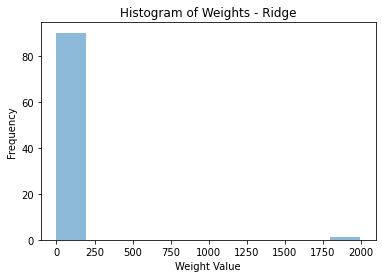

In [20]:
# fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(w_ridge, alpha=0.5, label='Ridge')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Histogram of Weights - Ridge')
plt.show()

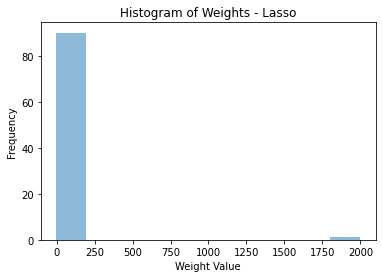

In [21]:
plt.hist(w_lasso, alpha=0.5, label='Lasso')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Histogram of Weights - Lasso')
plt.show()

**Plot a histogram of the weights for the ridge, lasso, and count regression models. Discuss
how the weights differ**

For Ridge and Lasso regression, the weight is quite similar. It means that the penalty term applied is not really significant to the model.

Lasso regression gives significantly lower loss. It's important to note that Lasso is better at handling multicollinearity by performing feature selection and shrinking the cofficient towards zero and more effective in handling outliers. This might indicates our data has high sparsity or multicollinearity which resulting in Lasso performs better than Ridge.  However, since the weights are similar, it means that both Ridge and Lasso are able to capture relationships between the attributes and target varible.

**Discuss and compare the behaviors of the models. Are there certain periods (ranges of
years) in which models perform better than others? Where are the largest errors across
models. Did regularization help for some models but not others?**


In [133]:
#Evaluate model L2
periods = [(1920, 1940), (1940, 1960), (1960, 1980), (1980, 2000), (2000, 2020)]

for period in periods:
    train_mask = (train_y >= period[0]) & (train_y < period[1])
    test_mask = (test_y >= period[1]) & (test_y < period[1]+20)
    train_x_period, train_y_period = train_x[train_mask], train_y[train_mask]
    test_x_period, test_y_period = test_x[test_mask], test_y[test_mask]

    # Train the model using mini-batch gradient descent
    weight, train_losses, test_losses = mini_batch_gradient_descent(train_x_period, train_y_period, test_x_period, test_y_period, batch_size=16, num_epochs=100, learning_rate=0.000001, weight_decay_factor=0.000001, loss_type='L2', weight_decay_form=None, momentum=False, momentum_factor=None)
    
    # Evaluate the performance of the model on the test set for the period
    y_pred = np.dot(test_x_period, weight)
    mse = np.mean(np.square(test_y_period - y_pred))
    print("Period:", period, "MSE:", mse)

Period: (1920, 1940) MSE: 1588034.4726395418
Period: (1940, 1960) MSE: 1628114.3251936354
Period: (1960, 1980) MSE: 126336.96155688511
Period: (1980, 2000) MSE: 152.80020733752733
Period: (2000, 2020) MSE: nan


From above, we could see that the model performs better starting from 1980. This is aligned with the histogram that we created above where the majority of the data coming from the later years.

In [24]:
#Evaluate L2
y_train_pred = np.dot(train_x, w_ridge)
train_rmse = np.sqrt(np.mean(np.square(train_y - y_train_pred)))
y_test_pred = np.dot(test_x, w_ridge)
test_rmse = np.sqrt(np.mean(np.square(test_y - y_test_pred)))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 9.553017156131503
Test RMSE: 9.514997213453276


In [25]:
#Evaluate L1
y_train_pred = np.dot(train_x, w_lasso)
train_rmse = np.sqrt(np.mean(np.square(train_y - y_train_pred)))
y_test_pred = np.dot(test_x, w_lasso)
test_rmse = np.sqrt(np.mean(np.square(test_y - y_test_pred)))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 9.905130300986148
Test RMSE: 9.817432819056688


From RMSE above, L1 Lasso Regression gives larger error compared to Ridge.

# Problem 5 - Softmax Properties


###1. Show that the softmax function is invariant to constant offsets to its input

\begin{align*}
softmax(a+c1) &= \frac{exp(a+c1)}{\sum_{j=1}^{n}exp(a_j+c)} \\
&= \frac{exp(a)exp(c1)}{\sum_{j=1}^{n}exp(a_j)exp(c)}\\
&= \frac{exp(a)}{\sum_{j=1}^{n}exp(a_j)} \times \frac{exp(c1)}{\sum_{j=1}^{n}exp(c)}{}\\
&= softmax(a) \times \frac{exp(c1)}{n \times exp(c)}{}\\
&= softmax(a) \times \frac{exp(c1-c)}{n}
\end{align*}

Since $\frac{exp(c1-c)}{n}$ is a constant, it doesn't depend on $a$ and it's proven that softmax function is invariant to constant offset to its input.


###2.  Why is the observation that the softmax function is invariant to constant offsets to its input important when implementing it in a neural network?

It's important that softmax function is invariant to constant offset to its input because it allows the model to be more robust to changes in input data. Adding or substracting a constant value from input data doesn't change the output of sofmax function and making the network to generalize better to new data that can improve reliability and accuracy.

# Problem 6 - Implementing Softmax Classifier

Write a function to load the data and the labels, which are returned as NumPy arrays.

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [199]:
from sklearn.model_selection import train_test_split

def load_iris_data(train_file, test_file):
    train_data = np.loadtxt(train_file)
    test_data = np.loadtxt(test_file)
    train_labels = train_data[:, 0].astype(int) -1
    train_features = train_data[:, 1:]
    test_labels = test_data[:, 0].astype(int) -1
    test_features = test_data[:, 1:]

    # Normalize the features to be between -1 and 1
    mean_train = np.mean(train_features, axis=0)
    std_train = np.std(train_features, axis=0)
    train_features = (train_features - mean_train) / std_train
    test_features = (test_features - mean_train) / std_train
    return train_features, train_labels, test_features, test_labels

iris_train = '/content/drive/MyDrive/Deep Learning/HW2/iris-train.txt'
iris_test = '/content/drive/MyDrive/Deep Learning/HW2/iris-test.txt'

X_train, y_train, X_test, y_test = load_iris_data(iris_train, iris_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(90, 2)
(51, 2)
(90,)
(51,)


##1. Implementation & Evaluation

* Use softmax loss with L2 weight decay regularization  
*  Use stochastic gradient descent with mini batches and momentum to minimize softmax loss of single LNN (use environment's BLAS)
* Loop over epochs and mini batches (not individual vector/ matrices)
* 1000 epochs
* Normalize feature between -1 and 1
* Initial weight from Gaussian distribution

*Cross entropy loss*

$y_{i,j}$: true label for the $i$-th sample and $j$-th class

$p_{i,j}$: predicted probability for the $i$-th sample and $j$-th class. 
$$ L = - \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^C y_{i,j} \log(p_{i,j}) $$


In [200]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

# Define softmax function
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

# Define L2 regularization
def L2_regularization(W, lambd):
    return 0.5 * lambd * np.sum(W**2)

# Define cross-entropy loss
def cross_entropy_loss(y_pred, y_true):
    num_samples = y_pred.shape[0]
    y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
    correct_logprobs = -np.log(y_pred[range(num_samples), y_true])
    data_loss = np.sum(correct_logprobs) / num_samples
    return data_loss

# Define gradient function
def gradient(X, y, y_pred, W, b, lambd):
    num_samples = X.shape[0]
    dL_dy = y_pred
    dL_dy[range(num_samples), y] -= 1
    dL_dy /= num_samples
    dW = X.T.dot(dL_dy) + lambd * W
    db = np.sum(dL_dy, axis=0, keepdims=True)
    return dW, db

def softmax_classifier(X_train, y_train, X_test, y_test, num_epochs, batch_size, learning_rate = 0.01, momentum = 0.9, weight_decay = 0.01):
  
  # Initialize weights
  num_features = X_train.shape[1]
  num_classes = len(np.unique(y_train))
  W = np.random.normal(loc=0.0, scale=0.1, size=(num_features, num_classes))
  b = np.zeros(num_classes)

  # Initialize momentum
  V_dW = np.zeros_like(W)
  V_db = np.zeros_like(b)

  # Train the model
  for epoch in range(num_epochs):
      # Shuffle training data
      indices = np.random.permutation(X_train.shape[0])
      X_train = X_train[indices]
      y_train = y_train[indices]

      # Mini-batch training
      for i in range(0, X_train.shape[0], batch_size):
          X_batch = X_train[i:i+batch_size]
          y_batch = y_train[i:i+batch_size]

          # Forward pass
          z = X_batch.dot(W) + b
          y_pred = softmax(z)

          # Compute loss and regularization
          loss = cross_entropy_loss(y_pred, y_batch)
          reg_loss = loss + L2_regularization(W, weight_decay)

          # Compute gradients
          dW, db = gradient(X_batch, y_batch, y_pred, W, b, weight_decay)

          # Update weights and bias using momentum
          V_dW = momentum * V_dW - learning_rate * dW
          V_db = momentum * V_db - learning_rate * db
          W += V_dW
          b = b.reshape(-1, 1) + V_db.reshape(-1, 1)
          b = b.reshape(1, -1)

      # Compute and store training loss
      z_train = X_train.dot(W) + b
      y_pred_train = softmax(z_train)
      train_loss = cross_entropy_loss(y_pred_train, y_train)
      train_loss_list.append(train_loss)

      # Compute and store testing loss
      z_test = X_test.dot(W) + b
      y_pred_test = softmax(z_test)
      test_loss = cross_entropy_loss(y_pred_test, y_test)
      test_loss_list.append(test_loss)

      # Compute and store training accuracy
      y_pred_train_class = np.argmax(y_pred_train, axis=1)
      train_accuracy = np.mean(y_pred_train_class == y_train)
      train_accuracy_list.append(train_accuracy)

      # Compute and store testing accuracy
      y_pred_test_class = np.argmax(y_pred_test, axis=1)
      test_accuracy = np.mean(y_pred_test_class == y_test)
      test_accuracy_list.append(test_accuracy)
    
  y_pred_test = np.argmax(y_pred_test, axis=1)
  

  return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, y_pred_test, W, b

In [201]:
train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, y_pred_test, W, b= softmax_classifier(X_train, y_train, X_test, y_test,  num_epochs = 1000,batch_size = 64,learning_rate = 0.01,momentum = 0.9, weight_decay = 0.1)

Generate plot:
1. Cross-entropy loss during training as a function of number of epochs
2. Mean per class accuracy as a function of training epoch

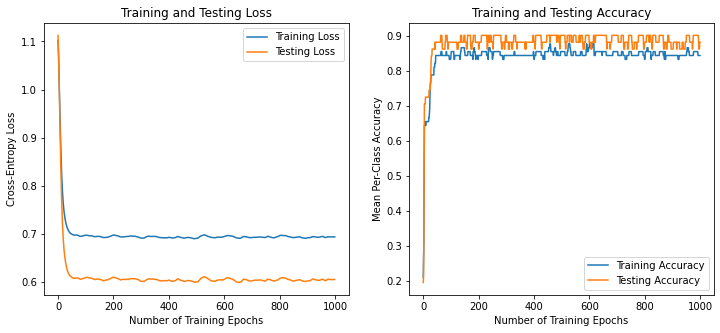

In [202]:
# Plot training and testing loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(test_loss_list, label="Testing Loss")
plt.xlabel("Number of Training Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training and Testing Loss")
plt.legend()

# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label="Training Accuracy")
plt.plot(test_accuracy_list, label="Testing Accuracy")
plt.xlabel("Number of Training Epochs")
plt.ylabel("Mean Per-Class Accuracy")
plt.title("Training and Testing Accuracy")
plt.legend()

plt.show()

In [203]:
print('Best test accuracy', np.max(test_accuracy_list))
print('Best train accuracy', np.max(train_accuracy_list))
print('Final test accuracy', test_accuracy_list[-1])
print('Final train accuracy', train_accuracy_list[-1])

Best test accuracy 0.9019607843137255
Best train accuracy 0.8777777777777778
Final test accuracy 0.8823529411764706
Final train accuracy 0.8444444444444444


**What is the best test accuracy your model achieved?**
Best test accuracy that the model has achieved is 90%

**What hyperparameters did you use?**
* learning_rate = 0.01
* num_epochs = 1000
* batch_size = 32
* momentum = 0.9
* weight_decay = 0.001

**Would early stopping have helped improve accuracy on the test data?** Early stopping could potentially help if the model is overfitting the training data and early stopping will allow the model to stop trainining once performance on test data stops improving. However, from the plot we can see that the model is not overfit the training data, therefore early stopping will not improve accuracy.


##2. Displaying Decision Boundaries
* Decision boundaries
* Scatter plot of training data

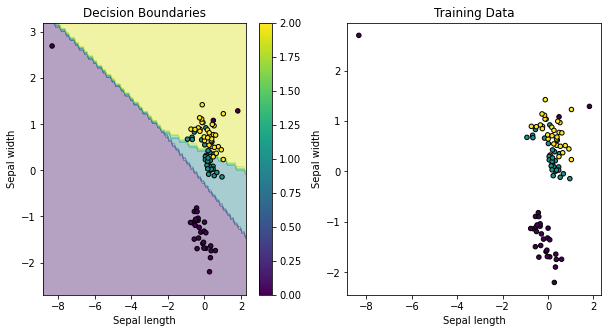

In [204]:
import matplotlib.pyplot as plt
# Display decision boundaries
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = np.argmax(softmax(np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), axis=1)
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k')
plt.title("Decision Boundaries")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.colorbar()

# Generate scatter plot of the training data with labels
plt.subplot(1, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k')
plt.title("Training Data")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.show()

##Problem 7- Classifying Images

In [211]:
from keras.datasets import cifar10
from matplotlib import pyplot as plt

%matplotlib inline

(X_train, y_train), (X_test, y_test)= cifar10.load_data()
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

In [206]:
import numpy as np
import pandas as pd

In [213]:
train_loss_list_cifar, test_loss_list_cifar, train_accuracy_list_cifar, test_accuracy_list_cifar, y_pred_test,W,b= softmax_classifier(X_train, y_train, X_test, y_test,  num_epochs = 100, batch_size = 64,learning_rate = 0.01,momentum = 0.9, weight_decay = 0.1)

a. Plot the training loss as a function of training epochs

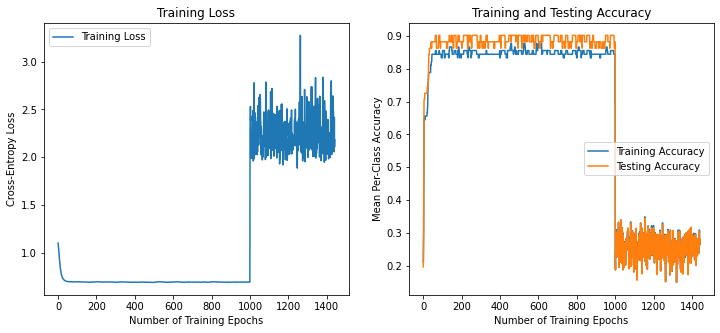

In [214]:
# Plot training and testing loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list_cifar, label="Training Loss")
plt.xlabel("Number of Training Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss")
plt.legend()

# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list_cifar, label="Training Accuracy")
plt.plot(test_accuracy_list_cifar, label="Testing Accuracy")
plt.xlabel("Number of Training Epochs")
plt.ylabel("Mean Per-Class Accuracy")
plt.title("Training and Testing Accuracy")
plt.legend()

plt.show()

b. Output the final test accuracy and a
normalized 10 ×10 confusion matrix computed on the test partition. Make sure to label
the columns and rows of the confusion matrix.

In [215]:
print('Final test accuracy', test_accuracy_list_cifar[-1])
print('Final train accuracy', train_accuracy_list_cifar[-1])

Final test accuracy 0.2632
Final train accuracy 0.26508


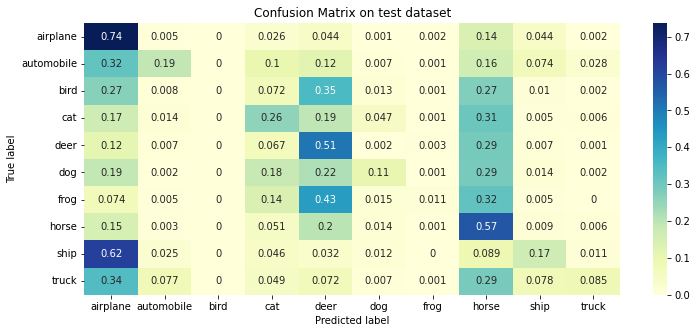

In [216]:
import seaborn as seaborn
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred_test, normalize = 'true')
categories= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
             'horse', 'ship', 'truck']
df_cm = pd.DataFrame(cf_matrix ,index = categories,
                  columns = categories)
plt.figure(figsize = (12,5))
ax = plt.axes()
seaborn.heatmap(df_cm, ax = ax, annot=True, cmap="YlGnBu")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title('Confusion Matrix on test dataset')
plt.show()